# Timeseries Features in BoFire: Preventing Data Leakage in Kinetic Measurements

This notebook demonstrates the importance of properly handling timeseries data in cross-validation when working with kinetic measurements. We'll show how improper cross-validation can lead to data leakage and overly optimistic performance metrics.

## Scenario: Catalytic Reaction Optimization

We're optimizing a catalytic reaction where we measure:
- **Yield** over time (focusing on yield for cross-validation demonstration)
- Variables: Temperature, Catalyst amount, Catalyst type (A, B, C), Base type (A, B, C), Base equivalents
- Each experiment consists of 8 time points (0, 15, 30, 45, 60, 90, 120, 180 minutes)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GroupKFold, KFold

import bofire.surrogates.api as surrogates
from bofire.data_models.domain.api import Domain, Inputs, Outputs
from bofire.data_models.enum import RegressionMetricsEnum
from bofire.data_models.features.api import (
    CategoricalInput,
    ContinuousInput,
    ContinuousOutput,
)
from bofire.data_models.kernels.api import HammingDistanceKernel, MaternKernel
from bofire.data_models.objectives.api import MaximizeObjective
from bofire.data_models.priors.api import MBO_LENGTHSCALE_PRIOR, MBO_NOISE_PRIOR
from bofire.data_models.surrogates.api import MixedSingleTaskGPSurrogate


# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Generate Synthetic Kinetic Data

We'll create realistic kinetic data with the following characteristics:
- Catalyst B doesn't work (no conversion)
- Base B doesn't work (no conversion)
- Catalyst A + Base A gives excellent yield
- High base loading increases impurities
- Temperature affects reaction rate

In [ ]:
def generate_kinetic_data(n_experiments: int = 16) -> pd.DataFrame:
    """Generate synthetic kinetic measurement data for catalytic reactions."""

    # Time points for kinetic measurements (in minutes)
    time_points = np.array([0, 15, 30, 45, 60, 90, 120, 180])

    # Generate experimental conditions
    experiments = []

    for exp_id in range(n_experiments):
        # Randomly sample conditions
        temperature = np.random.uniform(60, 100)  # °C
        catalyst_amount = np.random.uniform(1, 10)  # mol%
        base_equiv = np.random.uniform(1, 3)  # equivalents
        catalyst = np.random.choice(["A", "B", "C"])
        base = np.random.choice(["A", "B", "C"])

        # Generate kinetic profiles based on conditions
        for _i, time in enumerate(time_points):
            # Base reaction kinetics
            k_rate = 0.01 * (temperature - 50) / 50  # Temperature effect on rate

            # Catalyst effects
            if catalyst == "B":
                catalyst_factor = 0.0  # Catalyst B doesn't work
            elif catalyst == "A":
                catalyst_factor = 1.5  # Catalyst A is excellent
            else:  # catalyst == 'C'
                catalyst_factor = 0.7  # Catalyst C is moderate

            # Base effects
            if base == "B":
                base_factor = 0.0  # Base B doesn't work
            elif base == "A":
                base_factor = 1.2  # Base A is good
            else:  # base == 'C'
                base_factor = 0.8  # Base C is moderate

            # Synergistic effect: Catalyst A + Base A
            synergy = 1.5 if (catalyst == "A" and base == "A") else 1.0

            # Calculate yield (follows first-order kinetics)
            effective_rate = (
                k_rate * catalyst_factor * base_factor * synergy * catalyst_amount / 5
            )
            max_yield = min(
                95, 60 * catalyst_factor * base_factor * synergy
            )  # Asymptotic max
            yield_val = max_yield * (1 - np.exp(-effective_rate * time))

            # Calculate impurity (increases with base loading and time)
            impurity_rate = 0.002 * base_equiv * (temperature - 50) / 50
            impurity = 2 * base_equiv * (1 - np.exp(-impurity_rate * time))

            # Add some noise
            yield_val += np.random.normal(0, 2)
            impurity += np.random.normal(0, 0.5)

            # Add realistic noise to time measurements
            actual_time = time + np.random.normal(0, 0.5) if time > 0 else time

            experiments.append(
                {
                    "_trajectory_id": exp_id,
                    "time": actual_time,
                    "temperature": temperature,
                    "catalyst_amount": catalyst_amount,
                    "base_equiv": base_equiv,
                    "catalyst": catalyst,
                    "base": base,
                    "yield": max(0, yield_val),  # Ensure non-negative
                    "impurity": max(0, impurity),  # Ensure non-negative
                }
            )

    df = pd.DataFrame(experiments)
    # Add validity columns for BoFire
    df["valid_yield"] = 1
    df["valid_impurity"] = 1

    return df


# Generate the data
kinetic_data = generate_kinetic_data(n_experiments=16)
print(
    f"Generated {len(kinetic_data)} data points from {kinetic_data['_trajectory_id'].nunique()} experiments"
)
print("\nFirst few rows:")
kinetic_data.head(10)

Generated 128 data points from 16 experiments

First few rows:


,_trajectory_id,time,temperature,catalyst_amount,base_equiv,catalyst,base,yield,impurity,valid_yield,valid_impurity
0,0,0.000000,74.981605,9.556429,2.463988,A,A,0.000000,0.000000,1,1
1,0,14.765263,74.981605,9.556429,2.463988,A,A,33.628679,0.562401,1,1
2,0,29.767135,74.981605,9.556429,2.463988,A,A,52.252612,0.119179,1,1
3,0,44.137541,74.981605,9.556429,2.463988,A,A,65.710234,0.000000,1,1
4,0,60.157124,74.981605,9.556429,2.463988,A,A,73.651333,0.170375,1,1
5,0,90.732824,74.981605,9.556429,2.463988,A,A,83.852661,0.273337,1,1
6,0,119.287626,74.981605,9.556429,2.463988,A,A,90.243038,1.294397,1,1
7,0,179.424503,74.981605,9.556429,2.463988,A,A,92.994677,1.819754,1,1
8,1,0.000000,62.602064,9.539970,2.931264,B,B,0.751396,0.000000,1,1
9,1,15.926139,62.602064,9.539970,2.931264,B,B,0.000000,0.000000,1,1


## 2. Visualize the Kinetic Data

Let's visualize some of the kinetic profiles to understand our data better.

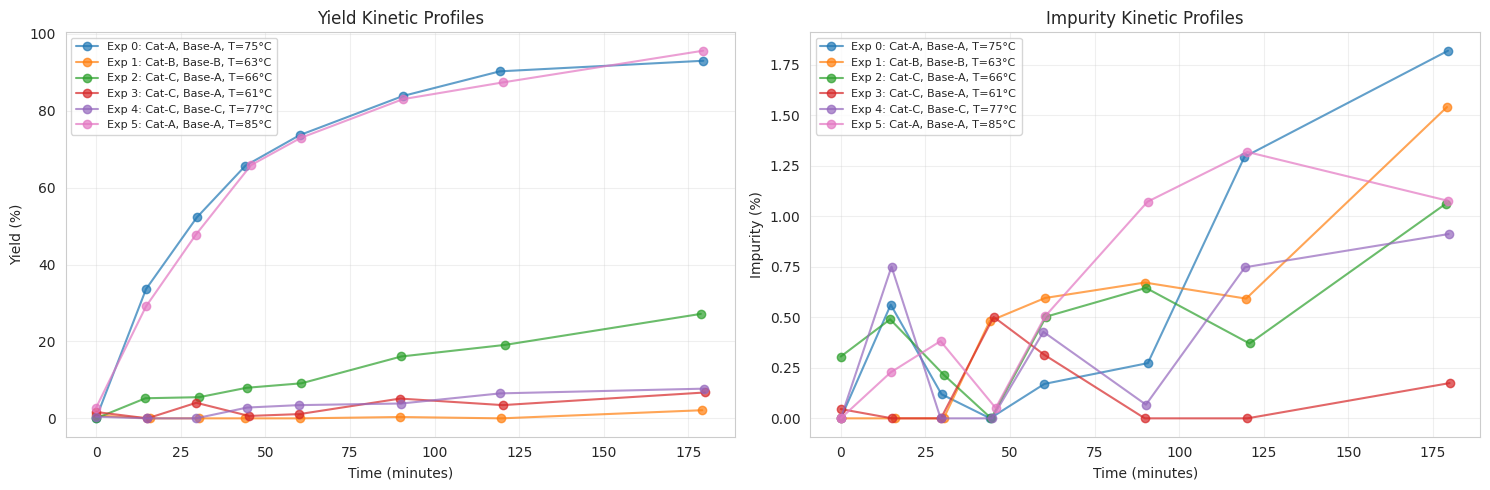


Catalyst-Base combinations in dataset:
catalyst  base
A         A       5
          C       3
B         B       1
          C       3
C         A       2
          B       1
          C       1


In [ ]:
# Plot kinetic profiles for a few experiments
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Select a few interesting experiments to plot
selected_exps = kinetic_data["_trajectory_id"].unique()[:6]
colors = plt.cm.tab10(np.linspace(0, 0.6, len(selected_exps)))

for idx, exp_id in enumerate(selected_exps):
    exp_data = kinetic_data[kinetic_data["_trajectory_id"] == exp_id].sort_values(
        "time"
    )

    # Get experiment conditions for label
    catalyst = exp_data.iloc[0]["catalyst"]
    base = exp_data.iloc[0]["base"]
    temp = exp_data.iloc[0]["temperature"]

    label = f"Exp {exp_id}: Cat-{catalyst}, Base-{base}, T={temp:.0f}°C"

    ax1.plot(
        exp_data["time"],
        exp_data["yield"],
        "o-",
        color=colors[idx],
        label=label,
        alpha=0.7,
    )
    ax2.plot(
        exp_data["time"],
        exp_data["impurity"],
        "o-",
        color=colors[idx],
        label=label,
        alpha=0.7,
    )

ax1.set_xlabel("Time (minutes)")
ax1.set_ylabel("Yield (%)")
ax1.set_title("Yield Kinetic Profiles")
ax1.legend(loc="best", fontsize=8)
ax1.grid(True, alpha=0.3)

ax2.set_xlabel("Time (minutes)")
ax2.set_ylabel("Impurity (%)")
ax2.set_title("Impurity Kinetic Profiles")
ax2.legend(loc="best", fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show distribution of catalyst/base combinations
print("\nCatalyst-Base combinations in dataset:")
combo_counts = kinetic_data.groupby(["catalyst", "base"])["_trajectory_id"].nunique()
print(combo_counts.to_string())

## 3. Define the Optimization Domain

We'll create two versions of the domain:
1. **Without** the `is_timeseries` flag (incorrect approach)
2. **With** the `is_timeseries` flag (correct approach)

In [ ]:
# Domain WITHOUT timeseries flag (incorrect)
def create_domain_without_timeseries() -> Domain:
    inputs = Inputs(
        features=[
            ContinuousInput(
                key="time",
                bounds=(0, 180),
                unit="min",
                # Note: is_timeseries=False (default)
            ),
            ContinuousInput(
                key="temperature",
                bounds=(60, 100),
                unit="°C",
            ),
            ContinuousInput(
                key="catalyst_amount",
                bounds=(1, 10),
                unit="mol%",
            ),
            ContinuousInput(
                key="base_equiv",
                bounds=(1, 3),
                unit="equiv",
            ),
            CategoricalInput(
                key="catalyst",
                categories=["A", "B", "C"],
            ),
            CategoricalInput(
                key="base",
                categories=["A", "B", "C"],
            ),
        ]
    )

    # Single output for cross-validation
    outputs = Outputs(
        features=[
            ContinuousOutput(
                key="yield",
                objective=MaximizeObjective(w=1.0),
                unit="%",
            ),
        ]
    )

    return Domain(inputs=inputs, outputs=outputs)


# Domain WITH timeseries flag (correct)
def create_domain_with_timeseries() -> Domain:
    inputs = Inputs(
        features=[
            ContinuousInput(
                key="time",
                bounds=(0, 180),
                unit="min",
                is_timeseries=True,  # Mark as timeseries!
            ),
            ContinuousInput(
                key="temperature",
                bounds=(60, 100),
                unit="°C",
            ),
            ContinuousInput(
                key="catalyst_amount",
                bounds=(1, 10),
                unit="mol%",
            ),
            ContinuousInput(
                key="base_equiv",
                bounds=(1, 3),
                unit="equiv",
            ),
            CategoricalInput(
                key="catalyst",
                categories=["A", "B", "C"],
            ),
            CategoricalInput(
                key="base",
                categories=["A", "B", "C"],
            ),
        ]
    )

    # Single output for cross-validation
    outputs = Outputs(
        features=[
            ContinuousOutput(
                key="yield",
                objective=MaximizeObjective(w=1.0),
                unit="%",
            ),
        ]
    )

    return Domain(inputs=inputs, outputs=outputs)


domain_without_ts = create_domain_without_timeseries()
domain_with_ts = create_domain_with_timeseries()

print("Domain created successfully!")
print(f"Inputs: {', '.join(domain_with_ts.inputs.get_keys())}")
print(f"Output: {', '.join(domain_with_ts.outputs.get_keys())}")

Domain created successfully!
Inputs: base_equiv, catalyst_amount, temperature, time, base, catalyst
Output: yield


## 4. Cross-Validation WITHOUT Timeseries Flag (Incorrect)

First, let's see what happens when we don't properly handle timeseries data. This approach will randomly split data points, potentially putting different time points from the same experiment in both training and test sets.

In [ ]:
# Create and train model without timeseries handling
# Use better priors for lengthscales and noise
model_spec_without_ts = MixedSingleTaskGPSurrogate(
    inputs=domain_without_ts.inputs,
    outputs=domain_without_ts.outputs,
    continuous_kernel=MaternKernel(
        ard=True, nu=2.5, lengthscale_prior=MBO_LENGTHSCALE_PRIOR()
    ),
    categorical_kernel=HammingDistanceKernel(ard=True),
    noise_prior=MBO_NOISE_PRIOR(),
)
model_without_ts = surrogates.map(model_spec_without_ts)

# Perform cross-validation (will use regular KFold, mixing time points from same experiments)
print("Performing cross-validation WITHOUT timeseries handling...")
print(
    "This will use regular KFold, potentially splitting time points from the same experiment.\n"
)

cv_train_no_ts, cv_test_no_ts, _ = model_without_ts.cross_validate(
    experiments=kinetic_data,
    folds=4,
    random_state=42,
)

# Get metrics for yield (RMSE = sqrt(MSD))
yield_metrics_no_ts = {
    "Train R²": float(cv_train_no_ts.get_metric(RegressionMetricsEnum.R2).iloc[0]),
    "Train RMSE": np.sqrt(
        float(cv_train_no_ts.get_metric(RegressionMetricsEnum.MSD).iloc[0])
    ),
    "Test R²": float(cv_test_no_ts.get_metric(RegressionMetricsEnum.R2).iloc[0]),
    "Test RMSE": np.sqrt(
        float(cv_test_no_ts.get_metric(RegressionMetricsEnum.MSD).iloc[0])
    ),
}

print("\n=== Results WITHOUT timeseries handling ===")
print("\nYield metrics:")
for metric, value in yield_metrics_no_ts.items():
    print(f"  {metric}: {value:.4f}")

print("\n⚠️ Note the suspiciously high test R² value!")

Performing cross-validation WITHOUT timeseries handling...
This will use regular KFold, potentially splitting time points from the same experiment.


=== Results WITHOUT timeseries handling ===

Yield metrics:
  Train R²: 0.9990
  Train RMSE: 1.0029
  Test R²: 0.9865
  Test RMSE: 3.7298

⚠️ Note the suspiciously high test R² value!


## 5. Cross-Validation WITH Timeseries Flag (Correct)

Now let's use the correct approach with the `is_timeseries` flag. This will ensure that all time points from the same experiment stay together in either training or test set.

In [ ]:
# Create and train model with proper timeseries handling
# Use better priors for lengthscales and noise
model_spec_with_ts = MixedSingleTaskGPSurrogate(
    inputs=domain_with_ts.inputs,
    outputs=domain_with_ts.outputs,
    continuous_kernel=MaternKernel(
        ard=True, nu=2.5, lengthscale_prior=MBO_LENGTHSCALE_PRIOR()
    ),
    categorical_kernel=HammingDistanceKernel(ard=True),
    noise_prior=MBO_NOISE_PRIOR(),
)
model_with_ts = surrogates.map(model_spec_with_ts)

# Perform cross-validation (will automatically use GroupKFold with _trajectory_id)
print("Performing cross-validation WITH timeseries handling...")
print("This will automatically detect the timeseries feature and use GroupKFold.")
print("All time points from the same experiment will stay together.\n")

cv_train_ts, cv_test_ts, _ = model_with_ts.cross_validate(
    experiments=kinetic_data,
    folds=4,
    random_state=42,
)

# Get metrics for yield (RMSE = sqrt(MSD))
yield_metrics_ts = {
    "Train R²": float(cv_train_ts.get_metric(RegressionMetricsEnum.R2).iloc[0]),
    "Train RMSE": np.sqrt(
        float(cv_train_ts.get_metric(RegressionMetricsEnum.MSD).iloc[0])
    ),
    "Test R²": float(cv_test_ts.get_metric(RegressionMetricsEnum.R2).iloc[0]),
    "Test RMSE": np.sqrt(
        float(cv_test_ts.get_metric(RegressionMetricsEnum.MSD).iloc[0])
    ),
}

print("\n=== Results WITH proper timeseries handling ===")
print("\nYield metrics:")
for metric, value in yield_metrics_ts.items():
    print(f"  {metric}: {value:.4f}")

print("\n✅ These are more realistic test metrics!")

Performing cross-validation WITH timeseries handling...
This will automatically detect the timeseries feature and use GroupKFold.
All time points from the same experiment will stay together.


=== Results WITH proper timeseries handling ===

Yield metrics:
  Train R²: 0.9991
  Train RMSE: 0.9549
  Test R²: 0.8544
  Test RMSE: 12.2661

✅ These are more realistic test metrics!


## 6. Compare Results: Data Leakage Analysis

Let's compare the cross-validation results to understand the impact of data leakage.

In [ ]:
# Create comparison dataframe
comparison_data = pd.DataFrame(
    {
        "Metric": ["Train R²", "Test R²", "Train RMSE", "Test RMSE"],
        "Without Timeseries": [
            yield_metrics_no_ts["Train R²"],
            yield_metrics_no_ts["Test R²"],
            yield_metrics_no_ts["Train RMSE"],
            yield_metrics_no_ts["Test RMSE"],
        ],
        "With Timeseries": [
            yield_metrics_ts["Train R²"],
            yield_metrics_ts["Test R²"],
            yield_metrics_ts["Train RMSE"],
            yield_metrics_ts["Test RMSE"],
        ],
    }
)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# R² Comparison
ax = ax1
x = np.arange(2)  # Train and Test
width = 0.35

train_no_ts = yield_metrics_no_ts["Train R²"]
test_no_ts = yield_metrics_no_ts["Test R²"]
train_ts = yield_metrics_ts["Train R²"]
test_ts = yield_metrics_ts["Test R²"]

# Bars for R²
bars1 = ax.bar(
    x - width / 2,
    [train_no_ts, test_no_ts],
    width,
    label="Without Timeseries",
    color=["lightblue", "lightcoral"],
    edgecolor=["darkblue", "darkred"],
    linewidth=2,
)
bars2 = ax.bar(
    x + width / 2,
    [train_ts, test_ts],
    width,
    label="With Timeseries",
    color=["lightgreen", "darkgreen"],
    edgecolor="darkgreen",
    linewidth=2,
)

ax.set_ylabel("R² Score")
ax.set_title("R² Comparison: Impact of Timeseries Handling")
ax.set_xticks(x)
ax.set_xticklabels(["Train", "Test"])
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

# RMSE Comparison
ax2 = ax2
train_rmse_no_ts = yield_metrics_no_ts["Train RMSE"]
test_rmse_no_ts = yield_metrics_no_ts["Test RMSE"]
train_rmse_ts = yield_metrics_ts["Train RMSE"]
test_rmse_ts = yield_metrics_ts["Test RMSE"]

bars3 = ax2.bar(
    x - width / 2,
    [train_rmse_no_ts, test_rmse_no_ts],
    width,
    label="Without Timeseries",
    color=["lightblue", "lightcoral"],
    edgecolor=["darkblue", "darkred"],
    linewidth=2,
)
bars4 = ax2.bar(
    x + width / 2,
    [train_rmse_ts, test_rmse_ts],
    width,
    label="With Timeseries",
    color=["lightgreen", "darkgreen"],
    edgecolor="darkgreen",
    linewidth=2,
)

ax2.set_ylabel("RMSE")
ax2.set_title("RMSE Comparison: Impact of Timeseries Handling")
ax2.set_xticks(x)
ax2.set_xticklabels(["Train", "Test"])
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

plt.tight_layout()
plt.show()

## 7. Understanding Data Leakage

Let's visualize exactly how data leakage occurs when we don't use proper timeseries handling.

In [ ]:
# from sklearn.model_selection import KFold


# Demonstrate data leakage with a single fold
kf = KFold(n_splits=4, shuffle=True, random_state=42)
train_idx, test_idx = next(kf.split(kinetic_data))

# Check which experiments have points in both train and test
train_experiments = set(kinetic_data.iloc[train_idx]["_trajectory_id"])
test_experiments = set(kinetic_data.iloc[test_idx]["_trajectory_id"])
leaked_experiments = train_experiments.intersection(test_experiments)

print("WITHOUT timeseries handling (regular KFold):")
print(f"Train experiments: {sorted(train_experiments)}")
print(f"Test experiments: {sorted(test_experiments)}")
print(f"\n🚨 Experiments split between train and test: {sorted(leaked_experiments)}")
print(
    f"Number of leaked experiments: {len(leaked_experiments)} out of {kinetic_data['_trajectory_id'].nunique()}"
)

# Show example of leakage for one experiment
if leaked_experiments:
    example_exp = list(leaked_experiments)[0]
    exp_data = kinetic_data[kinetic_data["_trajectory_id"] == example_exp]
    exp_train_idx = [i for i in train_idx if i in exp_data.index]
    exp_test_idx = [i for i in test_idx if i in exp_data.index]

    train_times = sorted(exp_data.loc[exp_train_idx, "time"].values)
    test_times = sorted(exp_data.loc[exp_test_idx, "time"].values)

    print(f"\nExample - Experiment {example_exp}:")
    print(f"  Total time points: {len(exp_data)}")
    print(
        f"  Time points in TRAIN: {len(exp_train_idx)} - Times: {[f'{t:.1f}' for t in train_times]}"
    )
    print(
        f"  Time points in TEST: {len(exp_test_idx)} - Times: {[f'{t:.1f}' for t in test_times]}"
    )
    print("\n  ⚠️ The model sees some time points during training and predicts")
    print("     neighboring time points during testing - this is cheating!")

print("\n" + "=" * 60)

# Now show correct handling
# from sklearn.model_selection import GroupKFold


gkf = GroupKFold(n_splits=4)
train_idx_correct, test_idx_correct = next(
    gkf.split(kinetic_data, groups=kinetic_data["_trajectory_id"])
)

train_experiments_correct = set(kinetic_data.iloc[train_idx_correct]["_trajectory_id"])
test_experiments_correct = set(kinetic_data.iloc[test_idx_correct]["_trajectory_id"])
leaked_experiments_correct = train_experiments_correct.intersection(
    test_experiments_correct
)

print("\nWITH timeseries handling (GroupKFold with _trajectory_id):")
print(f"Train experiments: {sorted(train_experiments_correct)}")
print(f"Test experiments: {sorted(test_experiments_correct)}")
print(
    f"\n✅ Experiments split between train and test: {sorted(leaked_experiments_correct) if leaked_experiments_correct else 'None'}"
)
print(f"Number of leaked experiments: {len(leaked_experiments_correct)}")
print("\n✅ Each experiment's complete kinetic profile stays together!")

WITHOUT timeseries handling (regular KFold):
Train experiments: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Test experiments: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

🚨 Experiments split between train and test: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Number of leaked experiments: 16 out of 16

Example - Experiment 0:
  Total time points: 8
  Time points in TRAIN: 6 - Times: ['14.8', '29.8', '44.1', '90.7', '119.3', '179.4']
  Time points in TEST: 2 - Times: ['0.0', '60.2']

  ⚠️ The model sees some time points during training and predicts
     neighboring time points during testing - this is cheating!


WITH timeseries handling (GroupKFold with _trajectory_id):
Train experiments: [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]
Test experiments: [3, 7, 11, 15]

✅ Experiments split between train and test: None
Number of leaked experiments: 0

✅ Each experiment's complete kinetic profile stays together!


## 8. Key Takeaways

### 🔑 **Critical Insights:**

1. **Data Leakage in Timeseries**: Without proper handling, cross-validation splits time points from the same experiment between train and test sets. The model learns to interpolate between neighboring time points rather than truly predicting new experiments.

2. **Overly Optimistic Metrics**: The test R² without timeseries handling is artificially high because the model has seen other time points from the same experiments during training.

3. **Proper Validation**: Using the `is_timeseries` flag ensures that complete kinetic profiles stay together, providing realistic performance estimates.

### 📋 **Best Practices for Kinetic/Timeseries Data:**

- Always mark your time feature with `is_timeseries=True`
- Include a `_trajectory_id` column to identify which measurements belong to the same experiment
- Use GroupKFold (default) or GroupShuffleSplit for cross-validation
- Be skeptical of suspiciously high test metrics - they might indicate data leakage!

### 🎯 **When to Use Timeseries Features:**

- Kinetic measurements (reaction progress over time)
- Process monitoring (temperature, pressure profiles)
- Batch processes (fermentation, crystallization)
- Any sequential measurements where order and grouping matter

## 9. Bonus: Using GroupShuffleSplit for Flexible Test Size

Sometimes you might want more control over your test set size. Here's how to use GroupShuffleSplit:

In [ ]:
# Cross-validation with GroupShuffleSplit
print("Using GroupShuffleSplit for flexible test set size...\n")

cv_train_shuffle, cv_test_shuffle, _ = model_with_ts.cross_validate(
    experiments=kinetic_data,
    folds=5,  # Number of random splits
    use_shuffle_split=True,  # Use GroupShuffleSplit instead of GroupKFold
    random_state=42,
)

print("GroupShuffleSplit Results (5 random 80/20 splits):")
print(
    f"Yield Test R²: {float(cv_test_shuffle.get_metric(RegressionMetricsEnum.R2).iloc[0]):.4f}"
)
print(
    f"Yield Test RMSE: {np.sqrt(float(cv_test_shuffle.get_metric(RegressionMetricsEnum.MSD).iloc[0])):.4f}"
)

Using GroupShuffleSplit for flexible test set size...

GroupShuffleSplit Results (5 random 80/20 splits):
Yield Test R²: 0.8629
Yield Test RMSE: 12.7704
